In [1]:
import os
import sys

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
module_path = os.path.abspath(os.path.join('../transfermarket/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from transfermarket import leagues, players, teams

In [2]:
prem_clubs_23 = leagues.get_prem_club_list(season="2023")
prem_clubs_23

{'Manchester City': '/manchester-city/startseite/verein/281/saison_id/2022',
 'Liverpool FC': '/fc-liverpool/startseite/verein/31/saison_id/2022',
 'Chelsea FC': '/fc-chelsea/startseite/verein/631/saison_id/2022',
 'Arsenal FC': '/fc-arsenal/startseite/verein/11/saison_id/2022',
 'Manchester United': '/manchester-united/startseite/verein/985/saison_id/2022',
 'Tottenham Hotspur': '/tottenham-hotspur/startseite/verein/148/saison_id/2022',
 'Aston Villa': '/aston-villa/startseite/verein/405/saison_id/2022',
 'West Ham United': '/west-ham-united/startseite/verein/379/saison_id/2022',
 'Newcastle United': '/newcastle-united/startseite/verein/762/saison_id/2022',
 'Leicester City': '/leicester-city/startseite/verein/1003/saison_id/2022',
 'Everton FC': '/fc-everton/startseite/verein/29/saison_id/2022',
 'Wolverhampton Wanderers': '/wolverhampton-wanderers/startseite/verein/543/saison_id/2022',
 'Brighton & Hove Albion': '/brighton-amp-hove-albion/startseite/verein/1237/saison_id/2022',
 'Br

In [10]:
list(prem_clubs_23.items())[14:][0][0]

'Southampton FC'

In [11]:
prem_23_avail = {}
for team, team_url in list(prem_clubs_23.items())[14:]:
    print(f"grabbing data for {team}")

    team_avail_23 = []
    try:
        for player,url in teams.get_players(team_url).items():
            avail_df = players.get_player_availability("https://www.transfermarkt.com" + url,"2022")
            if avail_df is not None:
                team_avail_23.append(avail_df)

        team_avail_23 = pd.concat([df.loc[:,~df.columns.duplicated()] for df in team_avail_23])
        team_fix = teams.get_team_fixtures(team_url, "2022")

        team_fix_avail = team_avail_23.T.join(team_fix, how="right")

        num_players = len(team_avail_23)
        team_fix_avail = team_fix_avail.iloc[:, :num_players].T
        prem_23_avail[team] = team_fix_avail
    except Exception as e:
        print(e)
        print(f"failed for {team}")
        continue

grabbing data for Southampton FC
no match data found for https://www.transfermarkt.com/tino-livramento/leistungsdatendetails/spieler/503981/plus/1?saison=2022
grabbing data for Crystal Palace
no match data found for https://www.transfermarkt.com/james-mcarthur/leistungsdatendetails/spieler/41416/plus/1?saison=2022
grabbing data for Leeds United
no match data found for https://www.transfermarkt.com/stuart-dallas/leistungsdatendetails/spieler/158764/plus/1?saison=2022
grabbing data for Nottingham Forest
no match data found for https://www.transfermarkt.com/gustavo-scarpa/leistungsdatendetails/spieler/330085/plus/1?saison=2022
no match data found for https://www.transfermarkt.com/omar-richards/leistungsdatendetails/spieler/424881/plus/1?saison=2022
no match data found for https://www.transfermarkt.com/harry-arter/leistungsdatendetails/spieler/55742/plus/1?saison=2022
grabbing data for Fulham FC
grabbing data for AFC Bournemouth
no match data found for https://www.transfermarkt.com/david-b

In [12]:
import pickle
with open("prem_23_avail", "xb") as f:
    pickle.dump(prem_23_avail, f)

In [14]:
with open("prem_23_avail", "rb") as f:
    prem_23_avail = pickle.load(f)

In [69]:
prem_injury_counts = {}
for team, df in prem_23_avail.items():
    injury_sum_df = pd.DataFrame((df==0).sum(axis=0))
    injury_sum_df = injury_sum_df.rename({0:team}, axis=1)

    prem_injury_counts[team] = injury_sum_df

In [70]:
all_injury_dfs = [df for _, df in prem_injury_counts.items()]

In [82]:
all_injuries = pd.concat(all_injury_dfs, axis=1)

In [83]:
from datetime import datetime
all_injuries = all_injuries[all_injuries.index>=datetime(2022,8,5)].sort_index().fillna(method='bfill')

In [91]:
all_injuries = all_injuries.unstack().reset_index().rename({'level_0':'team'}, axis=1)

In [97]:
all_injuries.head()

,team,Date,0
0,Manchester City,2022-08-05,1.0
1,Manchester City,2022-08-06,1.0
2,Manchester City,2022-08-07,1.0
3,Manchester City,2022-08-13,1.0
4,Manchester City,2022-08-14,1.0


In [93]:

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['font.family'] = 'JetBrains Mono'

/home/ismail/projects/football-data-viz/pl-23-injuries/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


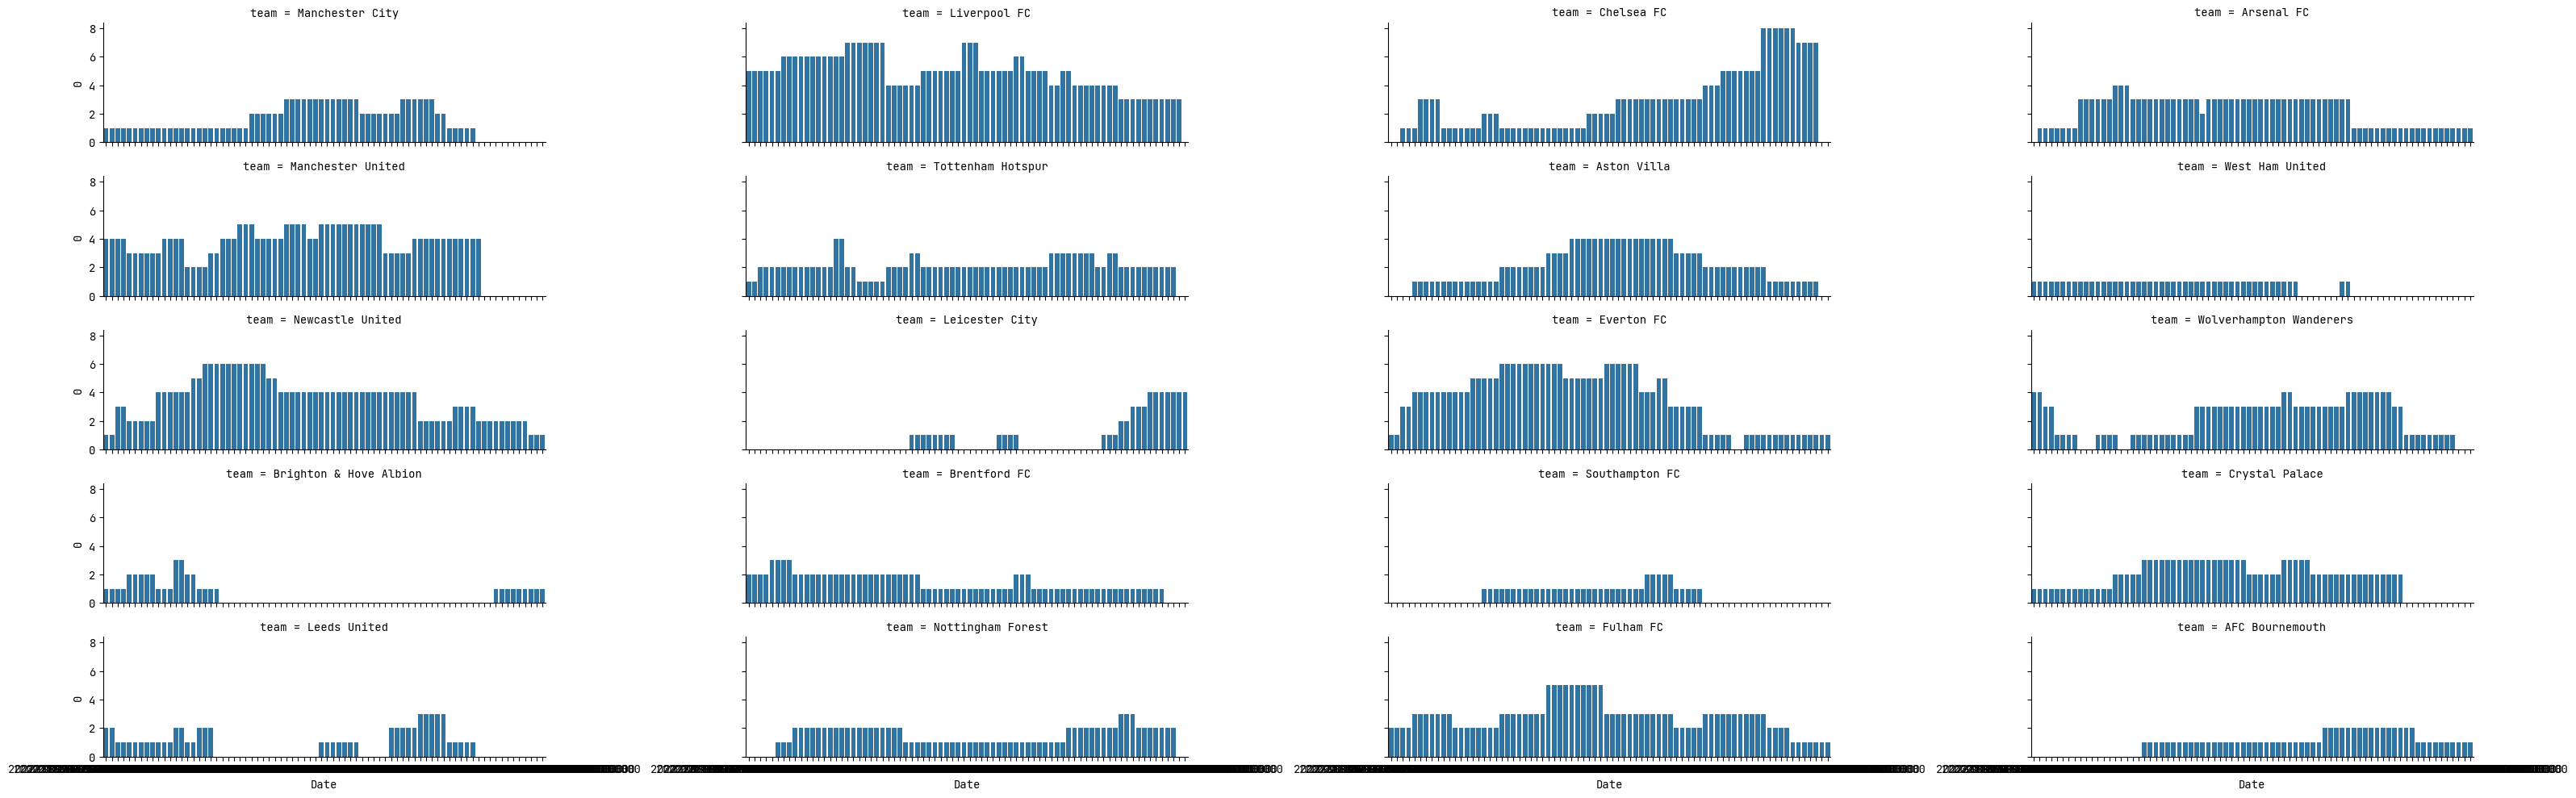

In [107]:
g=sns.FacetGrid(all_injuries, col='team', sharey=True, height=2, aspect=4, col_wrap= 4)
g.map(sns.barplot, 'Date', 0)